In [111]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
import pmdarima as pm
from dataclasses import dataclass
from typing import List
from tqdm import tqdm
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

from processing import Stationarizer, Normalizer
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner, get_64_tuner

In [112]:
data = pd.read_csv("data/YF_IBM.csv")["Adj Close"]
diff = data.dropna().to_numpy().reshape((-1, 1)) #data.diff().dropna().to_numpy().reshape((-1, 1))

train_idx = int(0.6 * np.shape(diff)[0])
val_idx = int(0.9 * np.shape(diff)[0])

train_data = diff[:train_idx]
val_data = diff[train_idx:val_idx]
non_test_data = diff[:val_idx]
test_data = diff[val_idx:]

In [113]:
scaler = StandardScaler()

scaler.fit(non_test_data)
train_data = scaler.transform(train_data)
val_data = scaler.transform(val_data)

In [114]:
train_ds = timeseries_dataset_from_array(
    train_data[:-20],
    train_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=False
)
val_ds = timeseries_dataset_from_array(
    val_data[:-20],
    val_data[20:],
    sequence_length=20,
    batch_size=64,
    shuffle=False
)

In [115]:
lstm = keras.Sequential()    
lstm.add(keras.Input(
      shape=(20, 1),
      batch_size=64,
      name="Inputs"
))
lstm.add(
    layers.LSTM(
        units=64,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.,
        recurrent_dropout=0.,
        return_sequences=True
    )
)
lstm.add(
    layers.LSTM(
        units=64,
        activation="tanh",
        recurrent_activation="sigmoid",
        dropout=0.,
        recurrent_dropout=0.,
        return_sequences=False
    )
)
lstm.add(
    layers.Dense(
        1,
        activation="linear"
    )
)
lstm.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss="mse",
    metrics=["mse"],
)

chkpt_path = "checkpoints/model_2-1-2/model_checkpoint.weights.keras"
chkpt_cb = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=chkpt_path,
    verbose=1,
    save_best_only=True
)

es_cb = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=25)

Epoch 1/50
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2000 - mse: 0.2000
Epoch 1: val_loss improved from inf to 0.04519, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1968 - mse: 0.1968 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 2/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0206 - mse: 0.0206
Epoch 2: val_loss improved from 0.04519 to 0.03431, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 3/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0107 - mse: 0.0107
Epoch 3: val_loss improved from 0.03431 to 0.03282, saving model to checkpoints/model_2-1-2/model_checkpoint.weights.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 4/50
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0105 - mse: 0.01

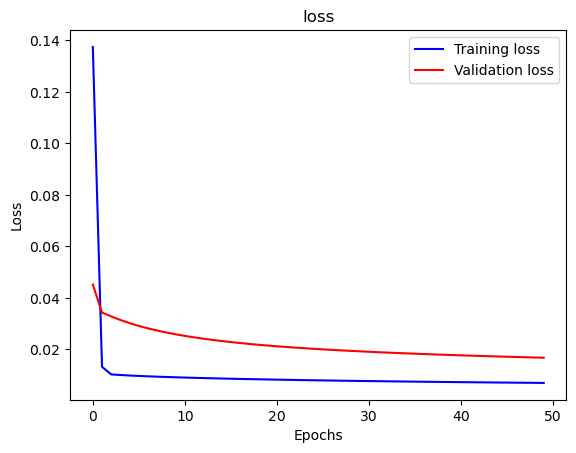

In [116]:
lstm_history = lstm.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[chkpt_cb, es_cb]
)

visualize_loss(lstm_history, "loss")

In [118]:
lstm_preds = []

for x, y in val_ds:
    yhat = lstm.predict(x)
    for el in range(x.shape[0]):
        lstm_preds.append(yhat[el])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━

2024-08-10 22:28:37.497925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [273]:
arima_train_data = scaler.inverse_transform(train_data).flatten()
hist = list(arima_train_data)
true_val = scaler.inverse_transform(val_data).flatten()

In [100]:
arima_preds = []
for step in tqdm(true_val):
    arima = ARIMA(hist, order=(3, 1, 0))
    arima_fit = arima.fit()
    guess = arima_fit.forecast()
    #print(guess)
    arima_preds.append(guess)
    hist.append(step)

100%|███████████████████| 1849/1849 [07:18<00:00,  4.22it/s]


In [122]:
arima_preds = np.array(arima_preds)
arima_preds

array([[120.29350034],
       [121.01266308],
       [120.91716105],
       ...,
       [118.94337693],
       [119.99095239],
       [119.55376543]])

In [110]:
x = np.arange(lstm_preds.shape[0])
scaler.inverse_transform(lstm_preds)

array([[ 90.2640286 ],
       [ 90.18463713],
       [ 90.05060548],
       ...,
       [107.50443718],
       [107.9433862 ],
       [108.46162939]])

In [121]:
true = np.array(true).reshape((-1, 1))

In [126]:
X = np.hstack((scaler.transform(arima_preds)[21:-18], lstm_preds))
X

array([[1.21569816, 1.29648232],
       [1.17243132, 1.28767896],
       [1.12899899, 1.27719557],
       ...,
       [1.10201869, 0.99190295],
       [1.15057651, 1.0072341 ],
       [1.14143192, 1.02508581]])

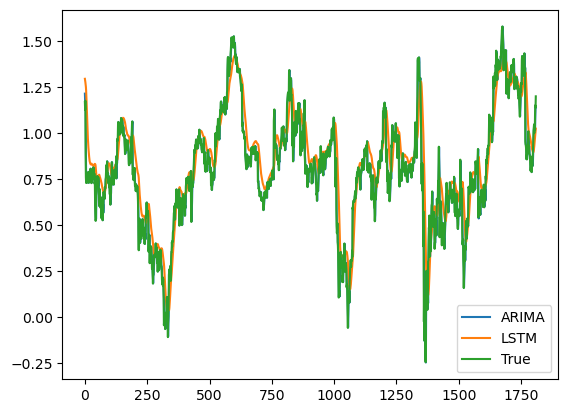

In [132]:
plt.plot(np.arange(X.shape[0]), X[:, 0], label="ARIMA")
plt.plot(np.arange(X.shape[0]), X[:, 1], label="LSTM")
plt.plot(np.arange(X.shape[0]), scaler.transform(true[21:-18]), label="True")
plt.legend()

In [222]:
test_data

array([[117.188797  ],
       [116.51193237],
       [115.20271301],
       [114.73068237],
       [121.21446228],
       [119.57566833],
       [118.02601624],
       [119.78944397],
       [118.96116638],
       [120.70677185],
       [122.23865509],
       [122.71068573],
       [122.14959717],
       [122.22975159],
       [122.03382874],
       [122.7195816 ],
       [120.34905243],
       [119.60090637],
       [117.31145477],
       [117.12217712],
       [116.43714142],
       [112.64243317],
       [112.08359528],
       [111.69602203],
       [110.02850342],
       [109.93838501],
       [111.93036652],
       [110.4250946 ],
       [109.37953186],
       [111.64192963],
       [113.50773621],
       [114.12966919],
       [113.63393402],
       [113.28240204],
       [113.76913452],
       [112.08359528],
       [111.73206329],
       [111.71404266],
       [113.24635315],
       [114.508255  ],
       [115.3374939 ],
       [116.05857086],
       [115.46368408],
       [116

In [241]:
test_ds = timeseries_dataset_from_array(
    scaler.transform(test_data[:-20]),
    scaler.transform(test_data[20:]),
    sequence_length=20,
    batch_size=64,
    shuffle=False
)
lstm_test_preds = lstm.predict(test_ds)
lstm.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1388 - mse: 0.1388


[0.3695383667945862, 0.3695383667945862]

In [242]:
len(lstm_test_preds)
lstm_test_preds_unsc = scaler.inverse_transform(lstm_test_preds)
np.max(lstm_test_preds_unsc)

144.66371

In [259]:
len(test_data)
true

array([117.188797  , 116.51193237, 115.20271301, 114.73068237,
       121.21446228, 119.57566833, 118.02601624, 119.78944397,
       118.96116638, 120.70677185, 122.23865509, 122.71068573,
       122.14959717, 122.22975159, 122.03382874, 122.7195816 ,
       120.34905243, 119.60090637, 117.31145477, 117.12217712,
       116.43714142, 112.64243317, 112.08359528, 111.69602203,
       110.02850342, 109.93838501, 111.93036652, 110.4250946 ,
       109.37953186, 111.64192963, 113.50773621, 114.12966919,
       113.63393402, 113.28240204, 113.76913452, 112.08359528,
       111.73206329, 111.71404266, 113.24635315, 114.508255  ,
       115.3374939 , 116.05857086, 115.46368408, 116.32898712,
       115.64395142, 116.50024414, 118.39309692, 118.50124359,
       118.92489624, 119.09614563, 117.19429016, 117.31145477,
       117.41962433, 116.17575073, 116.62643433, 115.86930084,
       115.13017273, 113.90434265, 113.55281067, 113.69702911,
       114.07559967, 113.72406769, 116.41010284, 124.67

In [244]:
val_idx

5547

In [245]:
len(data)

6164

In [253]:
arima_test_preds = []
#fhist = list(scaler.inverse_transform(non_test_data).flatten())
true = test_data.flatten()
fhist = data[:val_idx].to_list()

for step in tqdm(true):
    f_arima = ARIMA(fhist, order=(3, 1, 0))
    f_arima_fit = f_arima.fit()
    guess = f_arima_fit.forecast()
    arima_test_preds.append(guess)
    fhist.append(float(step))

100%|█████████████████████| 617/617 [02:07<00:00,  4.85it/s]


In [254]:
len(arima_test_preds[21:-18])

578

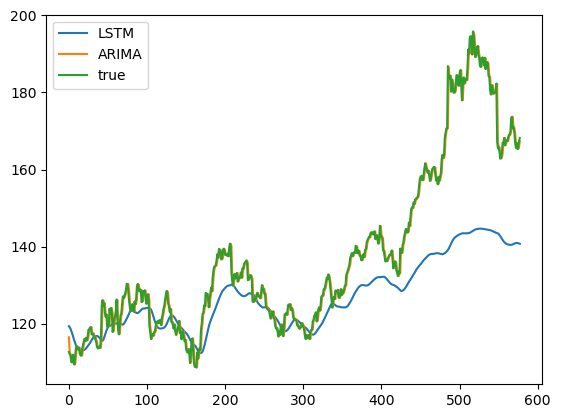

In [255]:
plt.plot(np.arange(len(lstm_test_preds)), scaler.inverse_transform(lstm_test_preds), label="LSTM")
plt.plot(np.arange(len(lstm_test_preds)), arima_test_preds[21:-18], label="ARIMA")
plt.plot(true[21:-18], label="true")
plt.legend()

In [278]:
outer = keras.Sequential()
outer.add(keras.Input(shape=(2, 1)))
outer.add(layers.Dense(16, activation="tanh"))
#outer.add(layers.Dense(16, activation="tanh"))
outer.add(layers.Dense(1, activation="linear"))
outer.compile(loss="mse", optimizer="adam")

ods = tf.data.Dataset.from_tensor_slices((X, scaler.transform(true_val[21:-18].reshape((-1, 1)))))
ods = ods.batch(32)

In [279]:
X_val = np.hstack((scaler.transform(arima_test_preds[21:-18]), lstm_test_preds))
outer_test_ds = tf.data.Dataset.from_tensor_slices((X_val, scaler.transform(np.array(true[21:-18]).reshape((-1, 1)))))
outer_test_ds = outer_test_ds.batch(32)

In [280]:
h = outer.fit(ods, epochs=1000, validation_data=outer_test_ds)

Epoch 1/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3934 - val_loss: 1.6986
Epoch 2/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355 - val_loss: 1.1522
Epoch 3/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 - val_loss: 1.0711
Epoch 4/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 - val_loss: 1.0120
Epoch 5/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - val_loss: 0.9526
Epoch 6/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206 - val_loss: 0.8960
Epoch 7/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185 - val_loss: 0.8431
Epoch 8/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0166 - val_loss: 0.7944
Epoch 9/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.7501
Epoch 10/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0138 - val_loss: 0.7101
Epoch 11/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0127 - val_loss: 0.6743
Epoch 12/1000
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

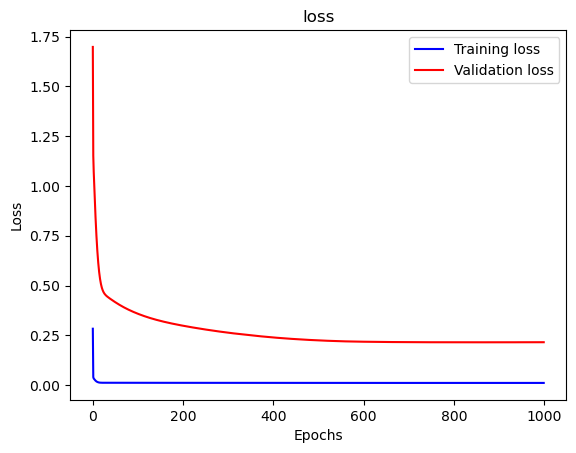

In [282]:
visualize_loss(h, "loss")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


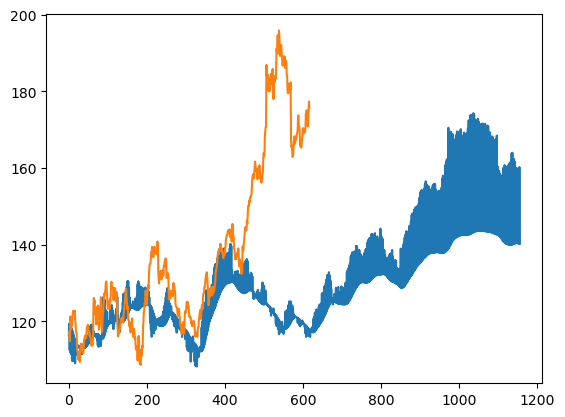

In [288]:
outer.predict(X_val)
toplot = scaler.inverse_transform(outer.predict(X_val).reshape((-1, 1)))
plt.plot(toplot)
plt.plot(test_data)